This notebook introduces some different visualizations of the GNDE (without training), as well as some utility methods intended to make iterating through examples easier.

In [1]:
import math
import torch
import torch.nn as nn
import torchdiffeq
import dgl
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/charleskulick/GNNProject/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Define the GCNLayer class with time-dependent weights and K-step message passing
class GCNLayer(nn.Module):
    def __init__(self, g: dgl.DGLGraph, in_feats: int, out_feats: int, activation: nn.Module, dropout: float, K: int = 1, bias: bool = True):
        super().__init__()
        self.g = g
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats, K))
        self.K = K
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_feats))
        else:
            self.bias = None
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout) if dropout else nn.Identity()
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / (self.weight.size(1) ** 0.5)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, h, t):
        g = self.g
        with g.local_scope():
            if isinstance(self.dropout, nn.Dropout):
                h = self.dropout(h)

            n = h.shape[0]
            h_out = torch.zeros(n, self.out_feats, device=h.device)
            
            # Add self-loop
            g = dgl.add_self_loop(g)

            # Compute D^-1/2
            degs = g.in_degrees().float()
            norm = torch.pow(degs, -0.5)
            norm[torch.isinf(norm)] = 0
            g.ndata['norm'] = norm.unsqueeze(1)

            # Compute S^k * h for k = 0, ..., K-1
            h_all = [h]
            for k in range(1, self.K):
                g.ndata['h'] = h_all[-1] * g.ndata['norm']
                g.update_all(dgl.function.copy_u('h', 'm'), dgl.function.sum('m', 'h'))
                h = g.ndata.pop('h') * g.ndata['norm']
                h_all.append(h)

            # Compute output features
            for i in range(self.out_feats):
                h_out_i = torch.zeros(n, device=h.device)
                for j in range(self.in_feats):
                    for k in range(self.K):
                        h_out_i += self.weight[j, i, k] * h_all[k][:, j]
                h_out[:, i] = h_out_i
            
            if self.bias is not None:
                h_out = h_out + self.bias
            if self.activation:
                h_out = self.activation(h_out)
            return h_out


# Custom Sequential module to handle additional arguments
class TimeDependentSequential(nn.Sequential):
    def forward(self, input, t):
        for module in self:
            input = module(input, t)
        return input

# Define the GDE function class with time-dependent weights
class GDEFunc(nn.Module):
    def __init__(self, gnn: nn.Module):
        """General GDE function class. To be passed to an ODEBlock"""
        super().__init__()
        self.gnn = gnn
        self.nfe = 0
    
    def set_graph(self, g: dgl.DGLGraph):
        for layer in self.gnn:
            layer.g = g
            
    def forward(self, t, x):
        self.nfe += 1
        x = self.gnn(x, t)
        return x

# Define the ODEBlock class
class ODEBlock(nn.Module):
    def __init__(self, odefunc: nn.Module, method: str = 'dopri5', rtol: float = 1e-3, atol: float = 1e-4, adjoint: bool = True):
        """Standard ODEBlock class. Can handle all types of ODE functions
        :method: str = {'euler', 'rk4', 'dopri5', 'adams'}
        """
        super().__init__()
        self.odefunc = odefunc
        self.method = method
        self.adjoint_flag = adjoint
        self.atol, self.rtol = atol, rtol

    def forward(self, x: torch.Tensor, T: int = 10):
        self.integration_time = torch.tensor([0, T]).float()
        self.integration_time = self.integration_time.type_as(x)

        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, self.integration_time,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                     rtol=self.rtol, atol=self.atol, method=self.method)
            
        return out[-1]
    
    def forward_batched(self, x: torch.Tensor, nn: int, indices: list, timestamps: set):
        """Modified forward for ODE batches with different integration times"""
        timestamps = torch.Tensor(list(timestamps))
        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, timestamps,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, timestamps,
                                     rtol=self.rtol, atol=self.atol, method=self.method)

        out = self._build_batch(out, nn, indices).reshape(x.shape)
        return out
    
    def _build_batch(self, odeout, nn, indices):
        b_out = []
        for i in range(len(indices)):
            b_out.append(odeout[indices[i], i*nn:(i+1)*nn])
        return torch.cat(b_out).to(odeout.device)
              
    def trajectory(self, x: torch.Tensor, T: int, num_points: int):
        self.integration_time = torch.linspace(0, T, num_points)
        self.integration_time = self.integration_time.type_as(x)
        out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                 rtol=self.rtol, atol=self.atol, method=self.method)
        return out


In [3]:
#This block contains code for several example graphons.
#Defined here are the symmetric functions W : [0,1]^2 -> [0,1]
# that give the probability of node connection.

def chung_lu_graphon(x, y, beta=0.5):
    return (x + y) % 1 < beta

def constant_graphon(x, y, c=0.1):
    return c

def multiplicative_graphon(x, y):
    return x * y

def gaussian_graphon(x, y, sigma=0.05):
    return np.exp(-((x - y) ** 2) / (2 * sigma ** 2))


#Given a function W of the correct form, make a DGL graph with N nodes:
def create_graph_from_graphon(W, N):

    #Generate underlying points in [0,1]
    points = np.linspace(0, 1, N)
    
    adj_matrix = np.zeros((N, N))
    
    #Fill the adjacency matrix with Bernoulli rv based on W
    for i in range(N):
        for j in range(N):
            if i != j:
                probability = W(points[i], points[j])
                adj_matrix[i, j] = np.random.binomial(1, probability)
    
    #Convert the adjacency matrix to a DGL graph
    src, dst = np.nonzero(adj_matrix)
    g = dgl.graph((src, dst), num_nodes=N)

    #Add self loops
    g = dgl.add_self_loop(g).to(device)

    #Add norm data to nodes
    degs = g.in_degrees().float()
    norm = torch.pow(degs, -0.5)
    norm[torch.isinf(norm)] = 0
    g.ndata['norm'] = norm.unsqueeze(1)

    return g

In [4]:
#NOTE: These are parameters to tune. Start here for new examples.
#Create the largest graph (true underlying graph)
N = 1001

#Define details of the graphon function you want to use.
beta = 0.8
def graphon_fn(x, y):
    return chung_lu_graphon(x, y, beta)

g = create_graph_from_graphon(graphon_fn, N)
g = g.to(device)

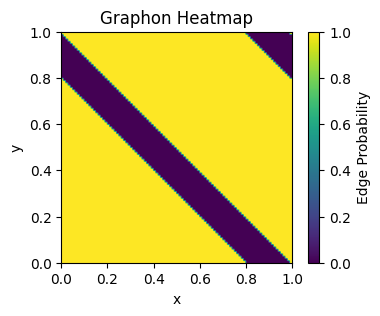

In [5]:
#Create some basic visualizations of the graphon.
#The heatmap of W will always be plotted.
#Change the line below to plot the entire graph also; this is worthless for large graphs, as it is just a mess of lines.
plot_actual_graph = False

#Heatmap plotting:

grid_resolution = 100

x = np.linspace(0, 1, grid_resolution)
y = np.linspace(0, 1, grid_resolution)
X, Y = np.meshgrid(x, y)

#Evaluate the graphon W on the grid
Z = graphon_fn(X, Y)

#Plot the heatmap
plt.figure(figsize=(4, 3))
plt.imshow(Z, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
plt.colorbar(label='Edge Probability')
plt.title('Graphon Heatmap')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


#Entire graph plotting:

if plot_actual_graph:

    #Function to visualize the graph with nodes at corresponding x but random y positions
    def visualize_graph_random_y(dgl_graph, title="Graph Visualization"):
        
        #Convert to NetworkX graph (just to visualize)
        nx_graph = dgl.to_networkx(dgl_graph)
        
        #Use positions based on np.linspace for x-axis and random for y-axis
        N = len(nx_graph.nodes())
        x_positions = np.linspace(0, 1, N)
        y_positions = np.random.rand(N) * 2 - 1 
        pos = {i: (x_positions[i], y_positions[i]) for i in range(N)}

        plt.figure(figsize=(4, 3))
        
        nx.draw(
            nx_graph,
            pos,
            node_size=300,
            with_labels=True,
            node_color="skyblue",
            edge_color="gray",
            alpha=0.7
        )
        
        plt.title(title)
        plt.show()

    visualize_graph_random_y(g.cpu(), "Full Graph Visualization")

In [6]:
#Here we define methods to extract a subgraph from the full graph.

#Find matching indices for two graph sizes:
def find_matching_indices(N, sub_N):

    k = (N-1)/(sub_N-1)

    if k % 1 != 0 or sub_N > N:
        print("Your subgraph size is not valid; the points in the interval corresponding to these two graphons will be different. Check that you are using a valid size of subgraph.")
    else:
        indices = np.array(range(sub_N)) * int(k)

    return indices

#Given an original graph g and a desired subgraph size sub_N, return the subgraph:
def extract_subgraph_from_graph(g, sub_N):

    N = g.num_nodes()
    matching_indices = find_matching_indices(N, sub_N)

    #Create the subgraph using the original graph
    subgraph = dgl.node_subgraph(g, matching_indices)

    #Move device and store norms.
    subgraph.to(device)
    degs = subgraph.in_degrees().float()
    norm = torch.pow(degs, -0.5)
    norm[torch.isinf(norm)] = 0
    subgraph.ndata['norm'] = norm.unsqueeze(1).to(device)

    return subgraph

In [7]:
#Utility method, quick divisor search.
def get_divisor(n):
    divisors = set()
    for i in range(2, int(math.sqrt(n)) + 1):
        if n % i == 0:
            divisors.add(i)
            if i != n // i:
                divisors.add(n // i)
    return np.array(sorted(divisors))

#Utility method to search for valid subgraph sizes for a given large N.
#This is somewhat nontrivial as we need to ensure our subgraphs use the same
# points as the full graph, so there is a divisibility property we need to ensure.
def get_list_of_subgraph_sizes(N):
    #Given N, valid subgraphs have size (N-1)/M+1 for valid divisors M.
    divs = get_divisor(N - 1)
    valid_sizes = (N - 1) / divs + 1
    return valid_sizes

#Print a list of valid subgraph sizes, so we can pick some to test.
print(get_list_of_subgraph_sizes(N))

[501. 251. 201. 126. 101.  51.  41.  26.  21.  11.   9.   6.   5.   3.]


In [8]:
#Define message passing neighborhood and num node hyperparams.
#These are shared through all architectures.
K_val = 1
node_features = 2

#Define sizes of graphs to use for GNNs examine.
#NOTE: We want subgraphs, so we need nodes in smaller sizes
# to be placed over nodes from the larger sized graphs.
# We need to be sure we use proper choices here.
graph_sizes = [N, 501, 251, 201, 21, 11]

#Populate an array with the graphs and models created.
graphs_and_models = []

for index, size in enumerate(graph_sizes):

    if index == 0:

        #For the largest graph, we already have a graph made.
        #We just need to build the models.

        gnn = TimeDependentSequential(
            GCNLayer(g=g, in_feats=node_features, out_feats=64, activation=nn.Softplus(), dropout=0, K=K_val),
            GCNLayer(g=g, in_feats=64, out_feats=64, activation=nn.Softplus(), dropout=0, K=K_val),
            GCNLayer(g=g, in_feats=64, out_feats=node_features, activation=None, dropout=0, K=K_val)
        ).to(device)

        gdefunc = GDEFunc(gnn).to(device)
        gde = ODEBlock(odefunc=gdefunc, method='rk4', atol=1e-3, rtol=1e-4, adjoint=False).to(device)

        graphs_and_models.append([g, gde])

    else:

        #For subgraphs, first make the subgraph, then the model, then copy parameters.
        subgraph = extract_subgraph_from_graph(g, size)

        #Define the new GNN
        new_gnn = TimeDependentSequential(
            GCNLayer(g=subgraph, in_feats=node_features, out_feats=64, activation=nn.Softplus(), dropout=0, K=K_val),
            GCNLayer(g=subgraph, in_feats=64, out_feats=64, activation=nn.Softplus(), dropout=0, K=K_val),
            GCNLayer(g=subgraph, in_feats=64, out_feats=node_features, activation=None, dropout=0, K=K_val)
        ).to(device)

        #Extract parameters from the original GNN (first in the list)
        original_parameters = {name: param.clone() for name, param in graphs_and_models[0][1].odefunc.gnn.named_parameters()}

        #Apply the extracted parameters to the new GNN
        for name, param in original_parameters.items():
            if name in new_gnn.state_dict():
                new_gnn.state_dict()[name].copy_(param.data)

        #Verify the parameters have been copied correctly
        for (name1, param1), (name2, param2) in zip(graphs_and_models[0][1].odefunc.gnn.named_parameters(), new_gnn.named_parameters()):
            assert torch.equal(param1, param2), f"Mismatch in parameter {name1}"
        print("Parameters copied successfully!")

        new_gdefunc = GDEFunc(new_gnn).to(device)
        new_gde = ODEBlock(odefunc=new_gdefunc, method='rk4', atol=1e-3, rtol=1e-4, adjoint=False).to(device)

        graphs_and_models.append([subgraph, new_gde])

Parameters copied successfully!
Parameters copied successfully!
Parameters copied successfully!
Parameters copied successfully!
Parameters copied successfully!


In [9]:
#Function to generate feature matrix.
#This applies each function in func_list to each sample point in sample_points.
#This way, the entire feature matrix is made at once.
def generate_features(sample_points, t, func_list):

    num_points = len(sample_points)
    num_features = len(func_list)
    
    # Initialize an array to store feature vectors
    feature_matrix = np.zeros((num_points, num_features))
    
    # Generate features for each sample point
    for i, u in enumerate(sample_points):
        features = [func(u, t) for func in func_list]
        feature_matrix[i, :] = np.concatenate(features)
    
    return feature_matrix


#Example 1D functions for feature generation
def func1(u, t):
    return np.array([np.sin(2 * np.pi * u + t)])

def func2(u, t):
    return np.array([np.cos(2 * np.pi * u - t) + u])

def func3(u, t):
    return np.array([2*u + 0.2])

#List of these 1D functions
func_list = [func1, func2]



#Next, generate features for all models:
for i, (graph, model) in enumerate(graphs_and_models):

    #Sample points from [0, 1]
    N = graph.num_nodes()
    sample_points = np.linspace(0, 1, N)

    #Set time t
    t = 0.0

    #Generate feature vectors for each sample point
    feature_vectors = generate_features(sample_points, t, func_list)

    #Convert feature vectors to PyTorch tensor
    features_new = torch.tensor(feature_vectors, dtype=torch.float32)

    graph = graph.to(device)
    features_new = features_new.to(device)
    graph.ndata['feat'] = features_new

    #Update the list with the modified graph
    graphs_and_models[i] = (graph, model)

In [10]:
#Define the piecewise constant function for plotting
def piecewise_constant(u_vect, v):
    n = len(v)
    interval_length = 1.0 / n
    out = np.zeros_like(u_vect)
    for index, u in enumerate(u_vect):
        found = False
        for i in range(n):
            if u >= i * interval_length and u < (i + 1) * interval_length:
                out[index] = v[i]
                found = True
        if not found:
            out[index] = v[-1]  # For u == 1, return the last element of v
    return out

In [11]:
#Now, we iterate through the models and get each solution,
# along with the corresponding error with the largest graph.

end_time = 1 #time to plot dynamics
test_points = 2000 #points to test output

errors = []
relerrors = []
fvals = []

for i, (graph, model) in enumerate(graphs_and_models):

    #Evaluate with this GNN
    Xn: torch.Tensor = graph.ndata['feat'].to(device)
    Yn = model(Xn, end_time)

    Xn_cpu = Xn.cpu().detach().numpy()
    Yn_cpu = Yn.cpu().detach().numpy()

    # Extract the first column
    #We previously had the difference here, now using just the feature.
    Yn_first_column = (Yn_cpu)[:, 0]

    # Generate points to test the function
    u_values = np.linspace(0, 1, test_points)
    f_values_n = piecewise_constant(u_values, Yn_first_column)

    if i > 0:

        #Calculate the error between the two outputs
        error = np.linalg.norm(fvals[0] - f_values_n)
        relerror = np.linalg.norm(fvals[0] - f_values_n) / np.linalg.norm(fvals[0])

        #Print the error
        print(f"Error between the two outputs: {error}")

        errors.append(error)
        relerrors.append(relerror)

    else:
        errors.append(0.)
        relerrors.append(0.)

    fvals.append(f_values_n)

Error between the two outputs: 0.14191065105323789
Error between the two outputs: 0.30963382795495065
Error between the two outputs: 0.39690280484079904
Error between the two outputs: 4.167270834038693
Error between the two outputs: 8.20528285263724


In [12]:
#This method creates snapshots of all features
# to allow for easy plotting over time.
end_time = 5
num_time_steps = 20

#Define time points to evaluate solution.
#Does not include 0 as this causes a network error.
time_steps = np.linspace(0, end_time, num=num_time_steps)[1:]

# Define the mesh of points at which to plot the values
x_axis_pts = 1000
u_values = np.linspace(0, 1, x_axis_pts)  # 1000 points between 0 and 1

evolutions = []
raw_out_feats_all = []

for graph, model in graphs_and_models:

    N = graph.num_nodes()
    init_feat = graph.ndata['feat']

    evolution_data = np.zeros(shape=(num_time_steps-1, x_axis_pts, node_features))
    raw_out_feats = np.zeros(shape=(num_time_steps-1, N, node_features))

    for i, t in enumerate(time_steps):

        output_features = model(init_feat, t)

        raw_out_feats[i, :, :] = output_features.cpu().detach().numpy()

        mapped_features = np.zeros(shape=(x_axis_pts, num_time_steps-1))

        for j in range(node_features):
            evolution_data[i,:,j] = piecewise_constant(u_values, output_features[:,j].cpu().detach().numpy().flatten())
    
    evolutions.append(evolution_data)
    raw_out_feats_all.append(raw_out_feats)


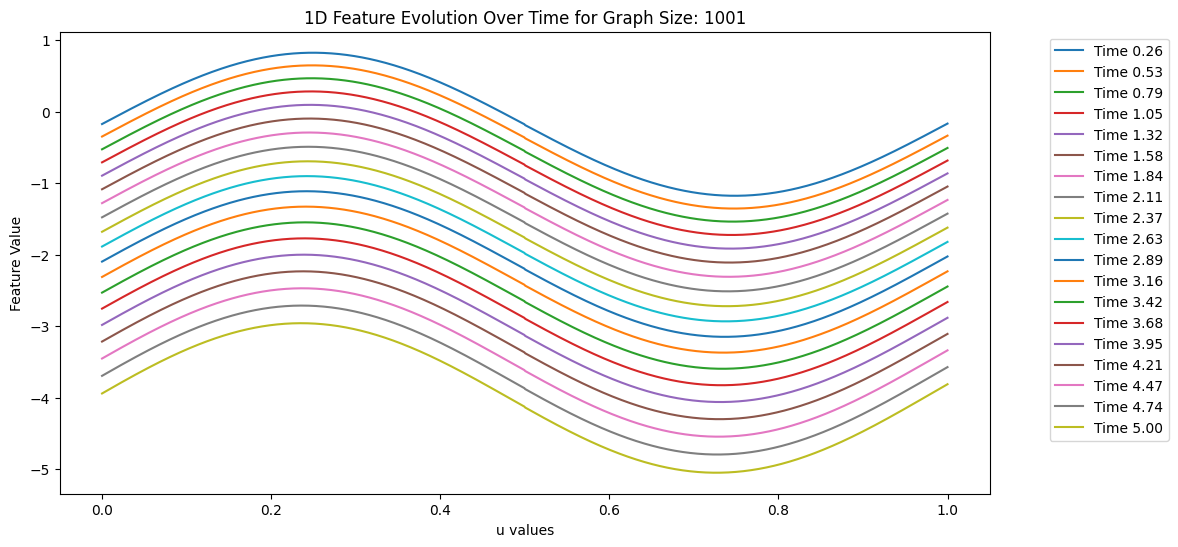

In [13]:
#Plot give feature evolution for the given graph.
graph_num = 0
feat_num = 0
evolution_data = np.array(evolutions[graph_num][:,:,feat_num])

#Plot each 1D slice of the feature
plt.figure(figsize=(12, 6))
for i in range(evolution_data.shape[0]):
    plt.plot(u_values, evolution_data[i], label=f'Time {time_steps[i]:.2f}')

plt.xlabel('u values')
plt.ylabel('Feature Value')
plt.title('1D Feature Evolution Over Time for Graph Size: ' + str(graph_sizes[graph_num]))
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

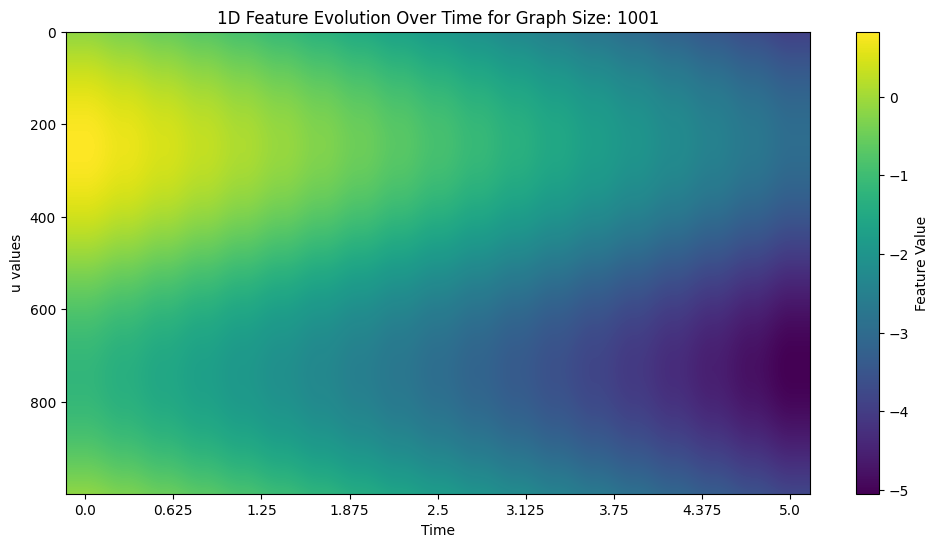

In [14]:
#Create a 2D plot of the evolution data for the given graph and feature.
#This plots each 1D slice side by side as time evolves, using color as the y-axis.
graph_num = 0
feat_num = 0
evolution_data = np.array(evolutions[graph_num][:,:,feat_num])

plt.figure(figsize=(12, 6))
plt.imshow(evolution_data.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Feature Value')
plt.xlabel('Time')
plt.ylabel('u values')

#Adjust x-axis to reflect the correct time interval.
#This may require some adjustment for different time intervals.
plt.xticks(ticks=np.linspace(0, num_time_steps-2, 9), labels=np.linspace(0, end_time, 9))

plt.title('1D Feature Evolution Over Time for Graph Size: ' + str(graph_sizes[graph_num]))
plt.show()

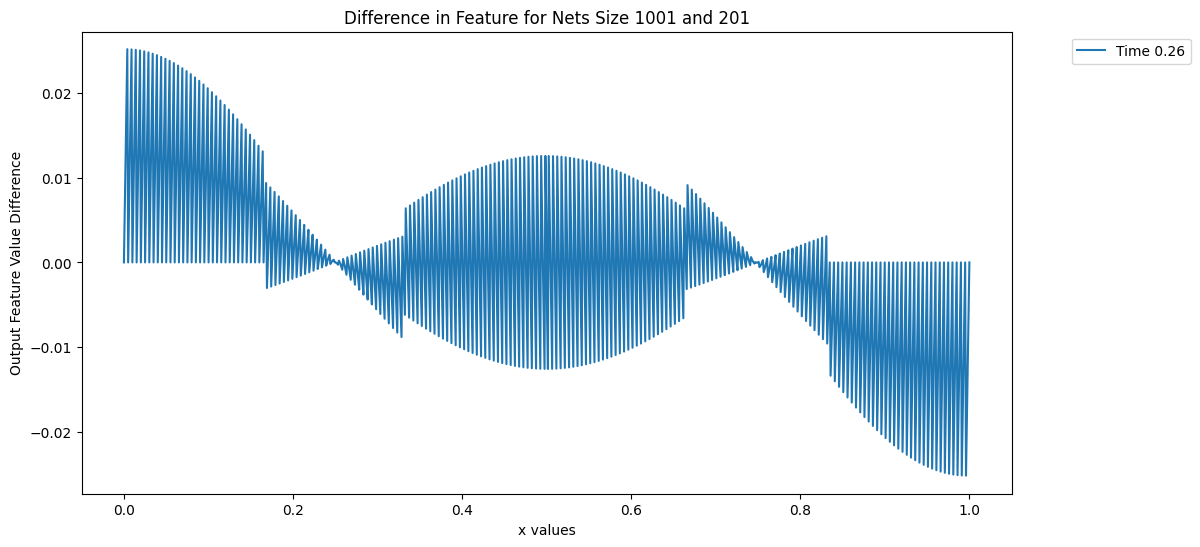

In [15]:
#Function to plot two superimposed solutions for two different networks.
#This result is save as a .gif in the current directory.
graph_num_1 = 0
graph_num_2 = 3
feat_num_1 = 0
feat_num_2 = 0
evolution_data_1 = np.array(evolutions[graph_num_1][:,:,feat_num_1])
evolution_data_2 = np.array(evolutions[graph_num_2][:,:,feat_num_2])

#Alternatively, because the output can be quite close between the two nets, we can plot the difference.
plot_difference = True

#Get plot bounds.
if plot_difference:
    global_min = np.min(evolution_data - evolution_data_2)
    global_max = np.max(evolution_data - evolution_data_2)
else:
    global_min = np.min([np.min(evolution_data), np.min(evolution_data_2)])
    global_max = np.max([np.max(evolution_data), np.max(evolution_data_2)])

#Define the function to update the plot for each frame:
def update(frame):
    plt.clf()
    if plot_difference:
        plt.plot(u_values, evolution_data[frame] - evolution_data_2[frame], label=f'Time {time_steps[frame]:.2f}')
        plt.title(f'Difference in Feature for Nets Size {graph_sizes[graph_num_1]} and {graph_sizes[graph_num_2]}')
        plt.ylabel('Output Feature Value Difference')
    else:
        plt.plot(u_values, evolution_data[frame], label=f'Time {time_steps[frame]:.2f}, Net Size {graph_sizes[graph_num_1]}')
        plt.plot(u_values, evolution_data_2[frame], label=f'Time {time_steps[frame]:.2f}, Net Size {graph_sizes[graph_num_2]}')
        plt.ylabel('Feature Value')
        plt.title('Superimposed Feature Evolution Over Time')
    plt.ylim(global_min, global_max)
    plt.xlabel('x values')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

# Create the figure and axis for the animation
fig, ax = plt.subplots(figsize=(12, 6))

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=len(time_steps), repeat=False)

# Save the animation as a GIF
ani.save('1d_dynamics_evolution.gif', writer='pillow', fps=10)
print("Animation saved as '1d_dynamics_evolution.gif'")


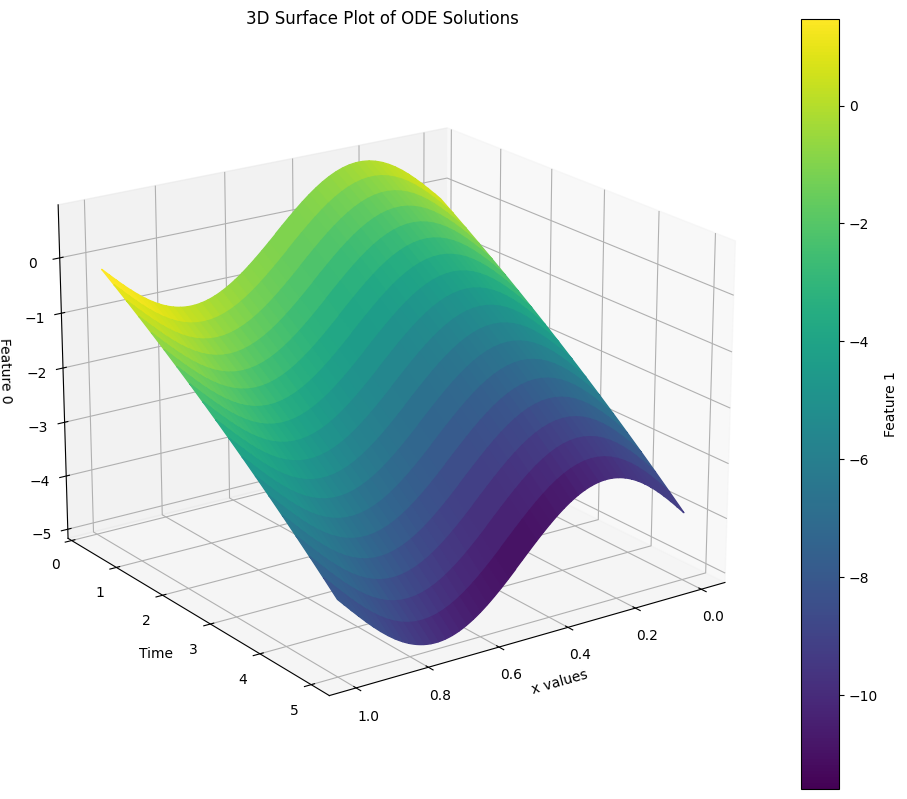

Surface plot saved as '3d_ode_surface.png'


In [16]:
#Plot a 3D surface showing two features at the same time evolving over time.
graph_num = 0
feat_num_1 = 0
feat_num_2 = 1
data = np.array(evolutions[graph_num][:,:,[feat_num_1, feat_num_2]])

# Create the figure and 3D axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

#Create the surface plot
norm = plt.Normalize(data[:, :, 1].min(), data[:, :, 1].max())
surf = ax.plot_surface(
    np.tile(u_values, (len(time_steps), 1)),
    np.tile(time_steps[:, np.newaxis], (1, x_axis_pts)),
    data[:, :, 0],
    facecolors=plt.cm.viridis(norm(data[:, :, 1])),
    shade=False
)

#Set labels and title
ax.set_xlabel('x values')
ax.set_ylabel('Time')
ax.set_zlabel(f'Feature {feat_num_1}')
ax.set_title('3D Surface Plot of ODE Solutions')

#Add color bar
m = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
m.set_array([])
cbar = fig.colorbar(m, ax=ax)
cbar.set_label(f'Feature {feat_num_2}')

#Adjust the viewing angle for visibility, depends on the features used.
ax.view_init(elev=20, azim=55)

plt.savefig('3d_ode_surface.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

print("Surface plot saved as '3d_ode_surface.png'")

In [17]:
#Particle system visualization.
#This uses the raw features of the network.
#Parameters: graph and features that we want to visualize.
graph_num = 4
feat_num_1 = 0
feat_num_2 = 1
features_to_plot = raw_out_feats_all[graph_num][:, :, [feat_num_1, feat_num_2]]

#Set up figure and limits
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(features_to_plot[:, :, 0].min(), features_to_plot[:, :, 0].max())
ax.set_ylim(features_to_plot[:, :, 1].min(), features_to_plot[:, :, 1].max())
ax.set_xlabel(f'Feature {feat_num_1}')
ax.set_ylabel(f'Feature {feat_num_2}')
ax.set_title('Features as Evolving Particles')

lines = [ax.plot([], [], '-o')[0] for _ in range(N)]

# Initialization function for the animation
def init():
    for line in lines:
        line.set_data([], [])
    return lines

# Update function for the animation
def update(frame):
    for i, line in enumerate(lines):
        x_data = features_to_plot[:frame+1, i, 0]
        y_data = features_to_plot[:frame+1, i, 1]
        line.set_data(x_data, y_data)
    ax.set_title(f'Evolution of Points Over Time (t = {time_steps[frame]:.2f})')
    return lines

# Create the animation
anim = FuncAnimation(fig, update, frames=(len(time_steps)-1), init_func=init, blit=True, interval=100)

# Save the animation
anim.save('point_evolution.gif', writer='pillow', fps=10)

plt.close(fig)

print("Animation saved as 'point_evolution.gif'")



Animation saved as 'point_evolution.gif'
